# Inhibitor Diffusion and Germination - Basic Setup

## Numerical experiments

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## 0. Prerequisite libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Mathematical framework

The presented model is used to simulate the dispersal of inhibitor concentrations $c$ over a square two-dimensional lattice, implementing the time-based diffusion equation with a diffusion coefficient $D$:

$$
\frac{\partial c}{\partial t}=D\nabla^2c.\tag{2}
$$

It is assumed that the lattice is discretised with equal subdivisions in every dimension: $\delta{x}=\delta{y}=1/N$, where $N$ is the number of lattice subdivisions along one dimension.

Time is discretised in steps of size $\delta t$. The left-hand side of the equation can be approximated by a forward finite difference to obtain

$$
\frac{\partial c}{\partial t}=\frac{c_{i,j}^{k+1}-c_{i,j}^{k}}{\delta{t}},
$$

where $i$ and $j$ are the discrete node indices in the $x$ and $y$ dimension, respectively, and $k$ is the time step index.

The Laplacian of the concentration can be expressed as

$$
\nabla^2c = \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}
$$

and each of the partial derivatives can be approximated as second-order forward finite differences:

$$
\frac{\partial^2 c}{\partial x^2} = \frac{c_{i+1,j}^{k}+c_{i-1,j}^{k}-2c_{i,j}^{k}}{\delta{x^2}}
$$

$$
\frac{\partial^2 c}{\partial y^2} = \frac{c_{i,j+1}^{k}+c_{i,j-1}^{k}-2c_{i,j}^{k}}{\delta{x^2}}
$$

Combining the above expression yields the update scheme:

$$
c_{i,j}^{k+1} = \frac{D\delta{t}}{\delta{x^2}}(c_{i+1,j}^{k}+c_{i-1,j}^{k}+c_{i,j+1}^{k}+c_{i,j-1}^{k}-4c_{i,j}^{k}) + c_{i,j}^{k}
$$

A periodic boundary is set in each dimension.

In [55]:
def diffusion_time_dependent(c_init, t_max, D=1.0, dt=0.001, L=1, n_save_frames=100):
    """
    Compute the evolution of a square lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (numpy.ndarray) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        L (float) - the length of the lattice along one dimension; defaults to 1;
        n_save_frames (int) - determines the number of frames to save during the simulation; detaults to 100
    outputs:
        u_evolotion (numpy.ndarray) - the states of the lattice at all moments in time.
    """

    assert c_init.ndim == 2, 'input array must be 2-dimensional'
    assert c_init.shape[0] == c_init.shape[1], 'lattice must have equal size along each dimension'

    # Determine number of lattice rows/columns
    N = c_init.shape[0]

    # Determine spatial increment
    dx = L / c_init.shape[0]

    if D * dt / (dx ** 2) > 0.5:
        print("Warning: inappropriate scaling of dx and dt, may result in an unstable simulation.")

    # Determine number of frames
    n_frames = int(np.floor(t_max / dt)) + 1
    print(f"Simulation running for {n_frames} steps.")

    # Array for storing lattice states
    c_evolution = np.zeros((n_save_frames + 1, N, N))
    times = np.zeros(n_save_frames + 1)
    save_interval = np.floor(n_frames / n_save_frames)
    save_ct = 0

    # Initialise current state
    c_curr = np.array(c_init)

    for t in range(n_frames):

        # Compute next state
        c_curr_bottom = np.roll(c_curr, -1, axis=0)
        c_curr_top = np.roll(c_curr, 1, axis=0)
        c_curr_left = np.roll(c_curr, -1, axis=1)
        c_curr_right = np.roll(c_curr, 1, axis=1)

        c_next = (D * dt / (dx ** 2)) * (c_curr_bottom + c_curr_top + c_curr_left + c_curr_right - 4 * c_curr) + c_curr
        
        # Update current array
        c_curr = np.array(c_next)

        # Save frame
        if t % save_interval == 0:
            c_evolution[save_ct] = np.array(c_curr)
            times[save_ct] = t * dt
            save_ct += 1

    return c_evolution, times

## 2. Experimental setup

As an initial assumption, the experiment uses the diffusion coefficient of glucose in water at temperature $T = 293.15 K$, which is $D_g=600 µm^2/s=0.0006 \textrm{mm}^2/s$[1].

In this experiment, a spore occupies a single node at the centre of a $W\times H$ lattice. At this node, an inhibitor concentration $c_i=c_{\textrm{max}}$ is defined, everywhere else the lattice is initiated with $c_i=0$.

The lattice spacing and size are thus calibrated to correspond to a typical size of a conidium, i.e. $\delta x = 5 \mu m$ and $L=200\delta x = 1 \textrm{mm}$.

In [60]:
# Initialise lattice with zero concentrations
W = 1001
H = 1001
c_lattice = np.zeros((W, H))

# Define spore index and set concentration
c_spore_init = 1
spore_idx = (W // 2, H // 2)
c_lattice[spore_idx] = c_spore_init

# Run simulation
D = 0.0006
L = 10
t_max = 10
c_evolution, times = diffusion_time_dependent(c_lattice, t_max=t_max, D=D, L=L, n_save_frames=100)

Simulation running for 10001 steps.


KeyboardInterrupt: 

In [57]:
# Analyse drop in concentration at spore location
c_thresh = 0.1*c_spore_init
time_thresh = 0

for t in range(len(times)):
    if c_evolution[t][spore_idx] < c_thresh:
        time_thresh = times[t]
        break

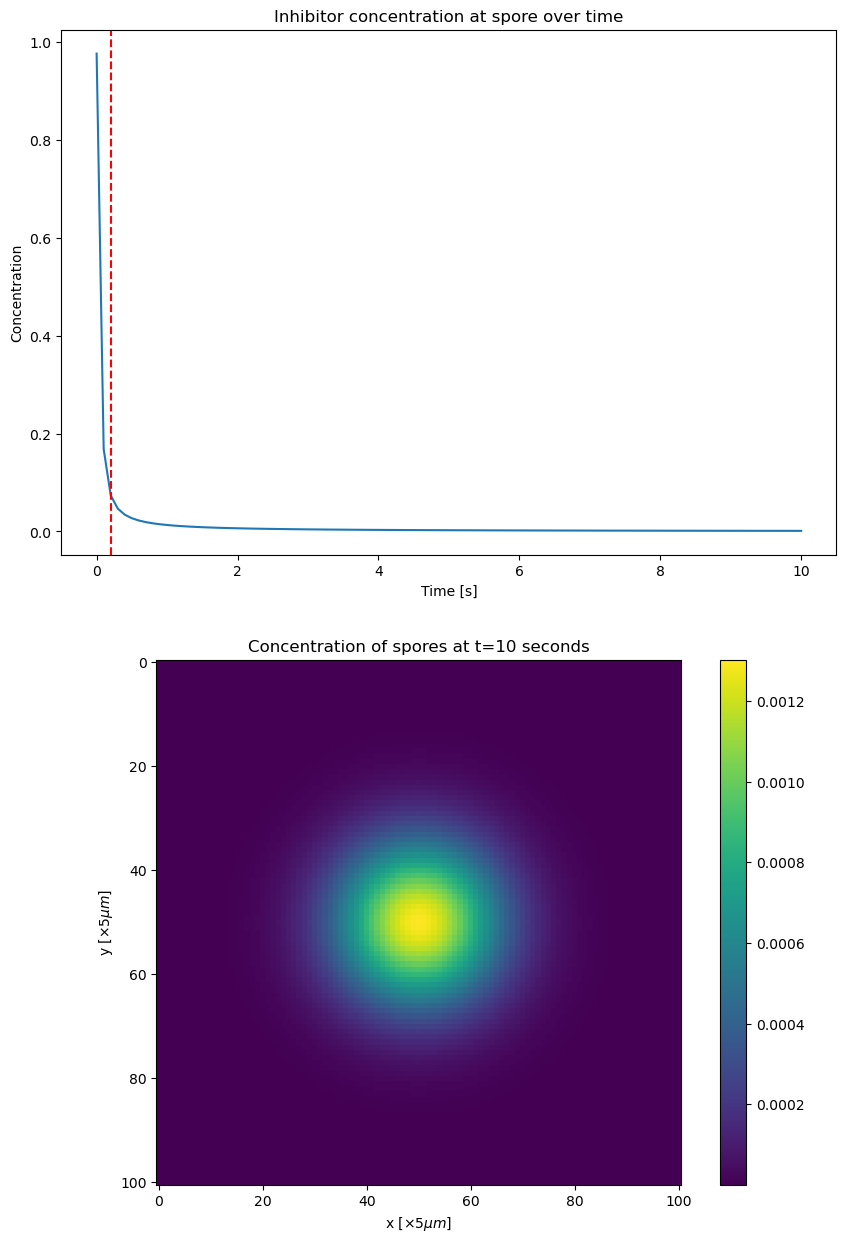

In [58]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
axs[0].plot(times, c_evolution[:, spore_idx[0], spore_idx[1]])
axs[0].axvline(x=time_thresh, color='r', linestyle='--')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Concentration')
axs[0].set_title('Inhibitor concentration at spore over time')
img = axs[1].imshow(c_evolution[-1], cmap='viridis')
axs[1].set_xlabel(f'x [$\\times 5\mu m$]')
axs[1].set_ylabel(f'y [$\\times 5\mu m$]')
axs[1].set_title(f'Concentration of spores at t={t_max} seconds')
fig.colorbar(img, ax=axs[1])

## References

[1] R. Hober, “Physical chemistry of cells and tissues,” 1945. [Online]. Available: https://api.semanticscholar.org/CorpusID:11597902